# Misdirection

Some experiments into how gpt2-small behaves when generating false output.

Semantic structure misdirects the model to produce incorrect output. For example,

> They realise John was two years older than Mary. Mary was born before ..."

In [1]:
import torch
from transformer_lens import HookedTransformer

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

torch.set_grad_enabled(False)

# NBVAL_IGNORE_OUTPUT
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

/Users/richardlayte/Work/layterz/experiments/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained model gpt2-small into HookedTransformer


In [2]:
from itertools import permutations, product
import einops
from fancy_einsum import einsum
from IPython.display import HTML
from circuitsvis.attention import attention_heads
from plotly import express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"

def calculate_logit_diff(cache):
    pred_tokens = torch.tensor([
        [model.to_single_token(c) for c in completions] 
        for _, completions in cache.prompts
    ]).to(device)

    resid_directions = cache.model.tokens_to_residual_directions(pred_tokens)
    return resid_directions[:, 0] - resid_directions[:, 1]

def calculate_head_contribution(cache, towards, layer=-1, pos_slice=-1):
    per_head_residual = cache.stack_head_results(
        layer=layer, pos_slice=pos_slice,
    )

    per_head_logit_diffs = einsum(
        "... batch d_model, batch d_model -> ...",
        per_head_residual, towards,
    )

    return einops.rearrange(
        per_head_logit_diffs,
        "(layer head_index) -> layer head_index",
        layer=cache.model.cfg.n_layers,
        head_index=cache.model.cfg.n_heads,
    )

def visualize_attention_patterns(heads, cache, token_labels=None):
    labels, patterns = [], []
    for head in heads:
        layer = head // cache.model.cfg.n_heads
        head_index = head % cache.model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")
        patterns.append(cache["attn", layer][0, head_index])

    patterns = torch.stack(patterns, dim=0)
    if token_labels is None:
        token_labels = [f"Token {i}" for i in range(cache['attn', 0].shape[-1])]

    return attention_heads(
        attention=patterns, tokens=token_labels, attention_head_names=labels
    ).show_code()

def generate_prompts(t):
    names = (" Mary", " John", " Alice")
    places = (" shops", " park", " beach")
    things = (" bag", " ball", " book")

    templates = [
        (
            t, (place, thing), permutations(names, 2),
        )
        for place, thing in product(places, things)
    ]

    return [
        (prompt.format(place, thing, S, IO), (IO, S))
        for prompt, (place, thing), names in templates
        for S, IO in names
    ]

def print_max_logits(cache, component='resid_post', layers=(-1,)):
    layer = -1
    resid_stream = cache[component, layer][0]
    resid_stream = cache.apply_ln_to_stack(resid_stream, layer)
    logits = cache.model.unembed(resid_stream)
    example_prompt = cache.model.to_str_tokens(cache.prompts[0][0])[1:]
    tokens = cache.model.to_tokens([p for p, _ in cache.prompts])
    pred_token = logits[0, -1, :].argmax(-1)
    pred = model.tokenizer.decode(pred_token)
    example_prompt += [pred]
    probs = cache.apply_ln_to_stack(logits, layer)
    token_probs = probs[:, :, tokens]
    fig = px.imshow(
        token_probs[-1, -1, -1, :].unsqueeze(0).cpu(),
        color_continuous_midpoint=0.0,
        color_continuous_scale="RdBu",
    )

    for x in range(len(example_prompt)):
        fig.add_annotation(x=x, y=0, text=example_prompt[x], showarrow=False, xshift=0, yshift=0, font=dict(size=16, color='white'))

    fig.update_layout(
        width=1200,  # Set the width of the graph
        height=800,  # Set the height of the graph
        xaxis=dict(showticklabels=False, showgrid=False, zeroline=False),
        yaxis=dict(showticklabels=False, showgrid=False, zeroline=False)
    )
    
    print(f'{"".join(example_prompt[:-1])} ...{pred[:5]} ({logits[:, -1, :].max():.2f}/{probs[:, -1, :].max():.2f})')
    return fig.show()

Create clean and corrupted prompt datasets where the corrupted prompts contradict the initial context. Each set is run against the model so we have access to clean and corrupted cached activations.

In [3]:
prompts = generate_prompts(
    "{2} was two years older than{3}. Who was born first?{2} was born before"
)

corrupted_prompts = generate_prompts(
    "{2} was two years older than{3}. Who was born first?{3} was born before"
)

_, cache = model.run_with_cache([p[0] for p in prompts])
cache.prompts = prompts

_, corrupted_cache = model.run_with_cache([p[0] for p in corrupted_prompts])
corrupted_cache.prompts = corrupted_prompts

prompts[0], corrupted_prompts[0]

((' Mary was two years older than John. Who was born first? Mary was born before',
  (' John', ' Mary')),
 (' Mary was two years older than John. Who was born first? John was born before',
  (' John', ' Mary')))

Below prints the tokens against the logit value for each. The generated output is added to the end.

 Mary was two years older than John. Who was born first? Mary was born before ... John (16.27/0.82)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


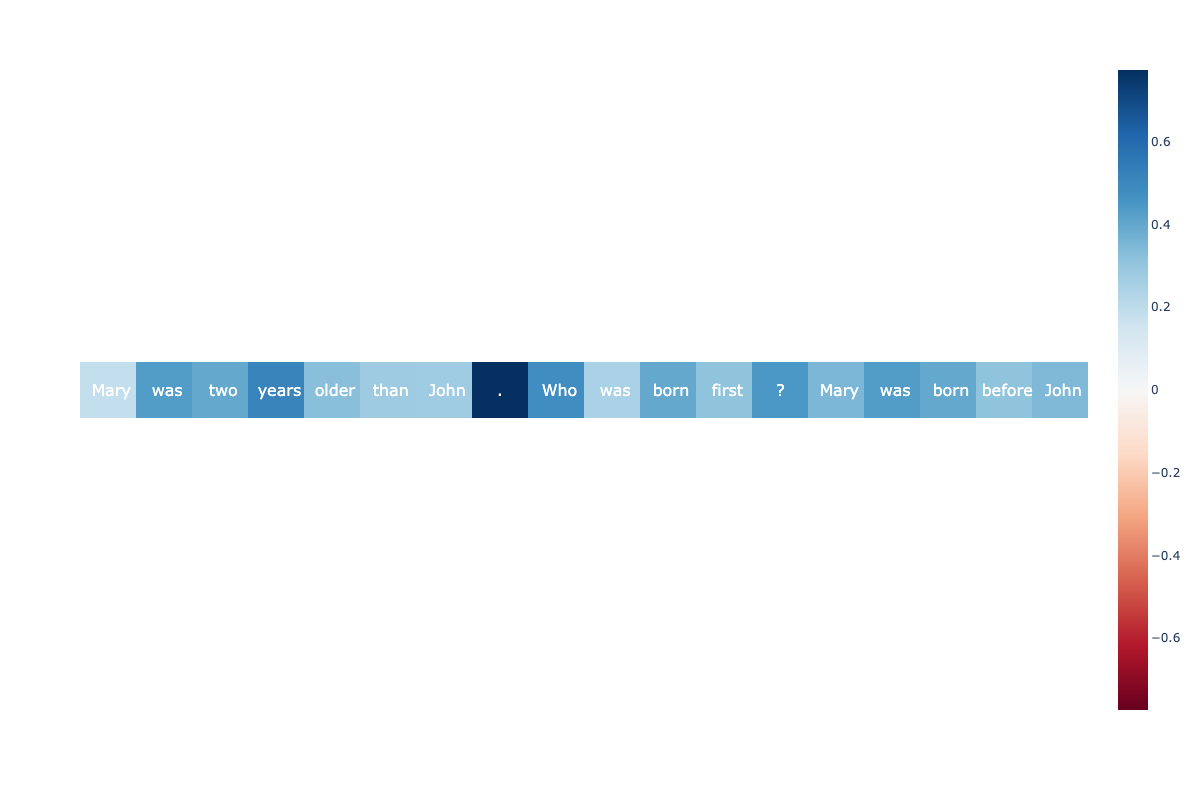

In [4]:
print_max_logits(cache)

 Mary was two years older than John. Who was born first? John was born before ... Mary (17.37/0.91)


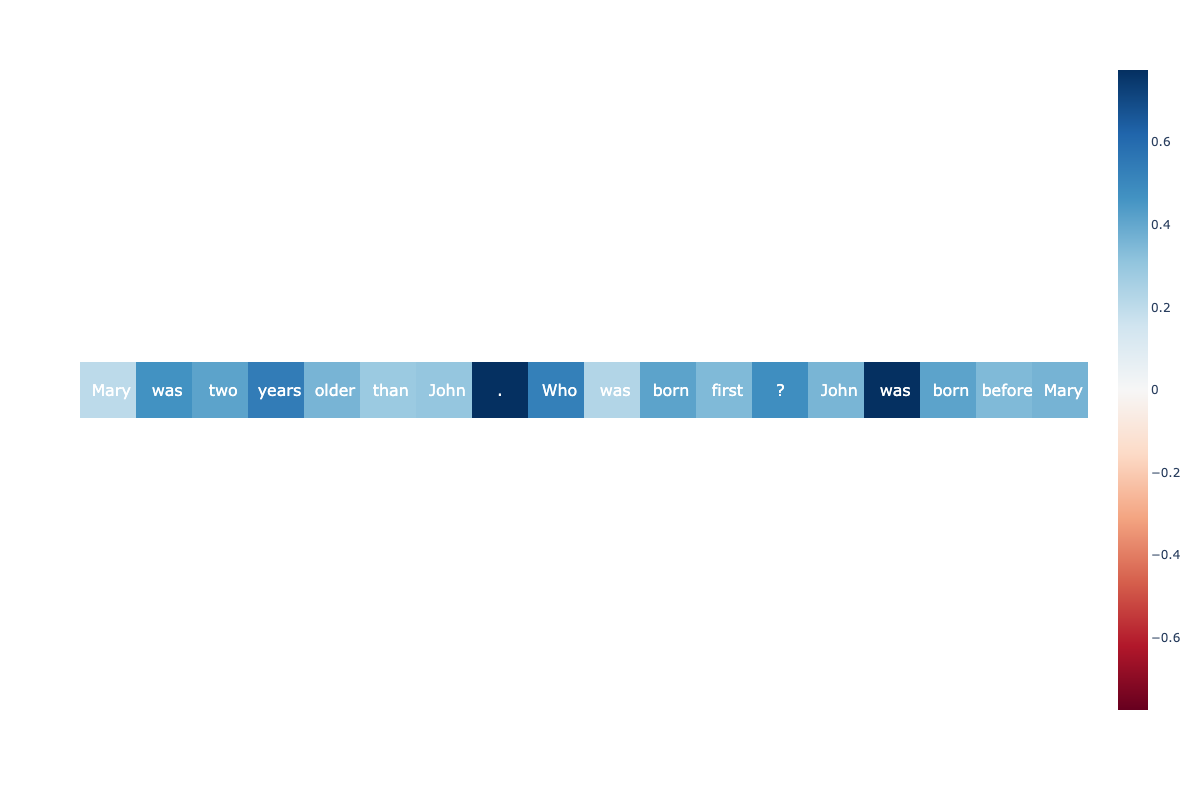

In [5]:
print_max_logits(corrupted_cache)

In [ ]:
fig = make_subplots(
    rows=2, cols=1, 
    subplot_titles=("Correct", "Corrupted"),
)

a = print_max_logits(cache)
b = print_max_logits(corrupted_cache)
fig.add_trace(a.data[0], row=1, col=1)
fig.add_trace(b.data[0], row=2, col=1)

layout = a.layout
fig.layout.coloraxis = layout.coloraxis
fig.update_yaxes(**layout.yaxis.to_plotly_json())
fig.layout.width = 1000
fig.layout.height = 600

fig.show()

Interestingly, in the corrupted prompt, we see a slightly increased confidence of the false output (~10% increase).

Looking at the attention head patterns many of the top positive and negative contributors are shared, but there are a few noteable exceptions.

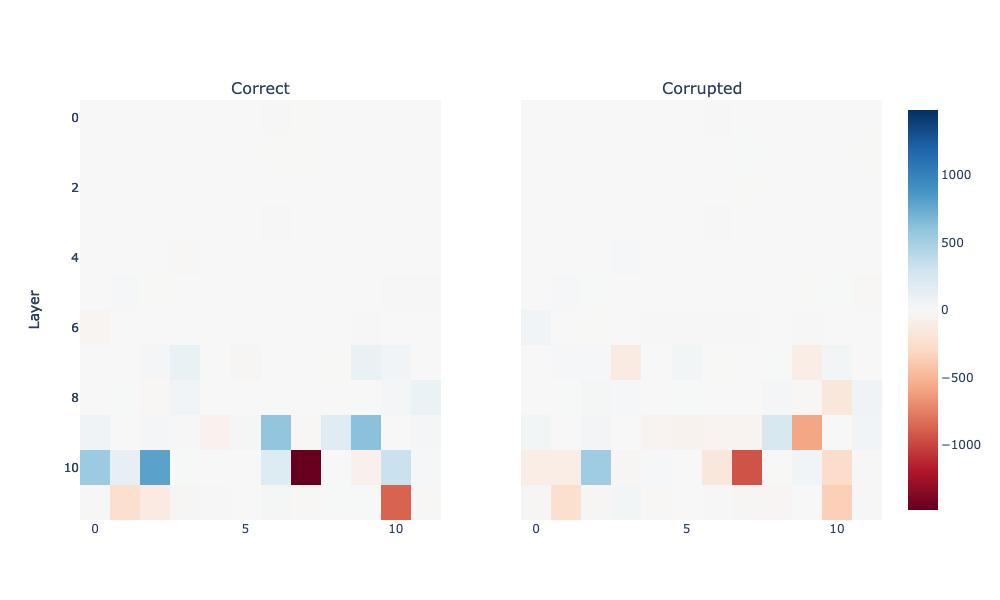

In [49]:
a = px.imshow(
    calculate_head_contribution(cache, calculate_logit_diff(cache)).cpu(),
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    color_continuous_midpoint=0.0,
    color_continuous_scale="RdBu",
)

b = px.imshow(
    calculate_head_contribution(corrupted_cache, calculate_logit_diff(corrupted_cache)).cpu(),
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head",
    color_continuous_midpoint=0.0,
    color_continuous_scale="RdBu",
)

fig = make_subplots(
    rows=1, cols=2, 
    subplot_titles=("Correct", "Corrupted"),
)
fig.add_trace(a.data[0], row=1, col=1)
fig.add_trace(b.data[0], row=1, col=2)

layout = a.layout
fig.layout.coloraxis = layout.coloraxis
fig.update_yaxes(**layout.yaxis.to_plotly_json())
fig.layout.width = 1000
fig.layout.height = 600

fig.show()

A couple of the top positive heads (e.g. 10.2, 9.8) are shared, but otherwise the top positive contributors for the clean inputs are the top negative contributors for the corrupted inputs (e.g. 9.9, 10.0, 10.6, etc). Many of these are name-mover heads from the IOI paper.

### Postive head patterns

We can dig into this further by looking at what those attention patterns attend to for each input.

In [13]:
logit_diff = calculate_logit_diff(cache)
per_head_logit_diffs = calculate_head_contribution(cache, logit_diff)
heads = torch.topk(per_head_logit_diffs.flatten(), k=12).indices
display(HTML(visualize_attention_patterns(heads, cache)))

corrupted_logit_diff = calculate_logit_diff(corrupted_cache)
corrupted_per_head_logit_diffs = calculate_head_contribution(corrupted_cache, corrupted_logit_diff)
corrupted_heads = torch.topk(corrupted_per_head_logit_diffs.flatten(), k=12).indices
HTML(visualize_attention_patterns(corrupted_heads, corrupted_cache))

### Negative head patterns

In [19]:
neg_heads = torch.topk(-per_head_logit_diffs.flatten(), k=12).indices
display(HTML(visualize_attention_patterns(neg_heads, cache)))

neg_corrupted_heads = torch.topk(-corrupted_per_head_logit_diffs.flatten(), k=12).indices
HTML(visualize_attention_patterns(neg_corrupted_heads, corrupted_cache))

### Interesting early heads

These heads standout when looking at the attention patterns because they show a clear difference between the true and false cases. For true statements the heads attend to the tokens representing the information in the previous sentence (e.g. Mary -> two and was -> years), but for false statements they attend to the period token.

In [15]:
indices = [
    (5, 5),
    (6, 9),
]

indices = [
    (i * model.cfg.n_heads + j)
    for i, j in indices
]

In [17]:
display(HTML(visualize_attention_patterns(indices, cache)))
HTML(visualize_attention_patterns(indices, corrupted_cache))

### All heads

In [21]:
HTML(visualize_attention_patterns(range(144), cache))

In [18]:
HTML(visualize_attention_patterns(range(144), corrupted_cache))